## Cantidad de P acciones posibles, dadas m materias restantes

In [52]:
def P(m) -> int:
    if m in [0,1]:
        return m
    else: 
        return sum([(nC(m, i+1) + P(m-(i+1))) for i in range(m)])

def nC (n, k) -> int:
    # numero combinatorio
    return (factorial(n) / (factorial(k) * factorial(n-k)))

def factorial (n) -> int:
    if n == 0:
        return 1
    else:
        return n*factorial(n-1)

Veo grafico comparativo de como escala la cantidad de computo por materias a ordenar

[1, 2, 3, 4]
[4.0, 12.0, 32.0, 80.0]


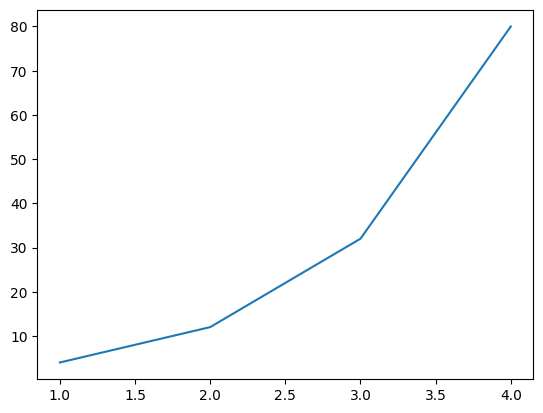

In [53]:
import matplotlib.pyplot as plt

rango_m = list(range(1,5))

print (rango_m)
print ([P(i+1) for i in rango_m])

plt.plot(rango_m, [P(i+1) for i in rango_m])
plt.show()

In [ ]:
class State ():
    def __init__ (self, materias_cursadas, materias_por_cursar):
        self.materias_cursadas = materias_cursadas
        self.materias_por_cursar = materias_por_cursar

    def possible_actions(self):
        return []

class Environment ():
    def __init__ (self, init_state):
        self.state = init_state

    def in_end_state (self):
        return self.state.possible_actions() == 0

In [54]:
class Agent ():
    def __init__ (self, alpha=0.5):
        self.alpha = alpha
        self.history = []

    def make_career_plan (self, initial_state):
        environment = Environment(initial_state)
        while not environment.in_end_state():
            best_action = self.pick_best_action(environment.state) # state contiene metodo state.possible_actions()
            environment.execute(best_action) # execute hace un environment.set_state(state')
            self.history.append((best_action, environment.state))
        return self.pretty_print_history()

    def pretty_print_history(self):
        return {}

    def R (self, state):
        # Reward of being in state s
        return 

    def Q (self, state, action):
        # Reward after applying action a from state s
        fake_env = Environment(state=state)
        post_state = fake_env.execute(action)
        post_action = self.pick_best_action(post_state)
        return self.R(state) + self.alpha * self.Q(post_state,post_action) 

    def pick_best_action (self, state):
        possible_actions = state.possible_actions()
        if len(possible_actions) > 0:
            best_choice = (0, possible_actions[0])
            max = self.Q(state, possible_actions[0])
            for j, a_ in enumerate(possible_actions[1:]):
                val = self.Q(state, a_)
                if best_choice[1] <= val:
                    best_choice = (j, val)
            return best_choice
        return 

SyntaxError: invalid syntax (1485929513.py, line 7)

In [ ]:
materias_cursadas = []
materias_por_cursar = []
initial_state = State(materias_cursadas, materias_por_cursar)

planes_de_carreras = []

nerd = Agent(alpha=0.7)
nerd.learn_course_plans(planes_de_carreras)
my_plan = nerd.make_career_plan(initial_state)

print (my_plan)

SyntaxError: incomplete input (375225820.py, line 2)